In [712]:
import numpy as np
from QAM_EncoderDecoder import * 
from scipy.io.wavfile import write, read
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
from IPython.display import Audio
from scipy import interpolate

%matplotlib inline

In [580]:
# constants

N = 2048
prefix_no = 256
fs = 44100

In [635]:
random_symbol = np.array([81, 41, 51, 46, 19, 27, 84, 53,  0, 86, 54, 17, 33, 32,  8, 24, 19,
       38, 58, 28, 74, 10, 39, 24, 39, 22, 59, 58, 70, 74, 82, 64,  4, 77,
       98, 50, 26, 36, 21, 32, 56, 27, 92, 42, 63, 91, 67, 76, 65, 40, 17,
       49, 66, 42, 87, 20, 50, 89, 48, 47, 40, 29, 57, 40, 92, 73,  8, 26,
       12, 76, 24, 82, 43, 14, 40, 19, 56, 97, 78, 43, 96, 43, 89,  6, 11,
       98, 58, 25, 91, 16, 40, 77, 52,  9, 34, 45, 36, 69, 12, 29, 38, 45,
       88, 14, 20, 49,  1, 61, 48, 36, 10, 44, 44,  5,  7, 34, 26, 72,  7,
       63, 68, 27, 12, 71, 39, 54, 96,  1, 70, 67, 76, 30, 77, 73, 28, 88,
       31, 17, 86, 62,  1, 12, 35, 74,  3, 87, 73, 26, 83, 73,  6,  3, 32,
       37, 39, 53, 90, 88, 60, 89, 93, 91,  4, 53,  5,  4,  4, 58, 35, 63,
       27, 77, 51, 87, 24, 31, 16,  4, 87, 98, 52, 90, 68, 37, 75, 56, 34,
       30, 50, 26, 20, 96, 51, 94, 60, 55, 14, 74,  4, 73, 13, 45, 67,  8,
       61, 12, 93,  6, 87, 14, 90, 64, 33, 29, 68, 13, 60, 18,  9, 60,  3,
       15,  6, 48, 34, 44, 63, 25, 39, 18,  5, 56, 38, 46,  6, 64, 36, 29,
       90, 47, 23, 29, 97, 19,  5, 47, 30, 63, 98, 99, 20, 91, 69, 24, 35,
       59])

bin_strings=''
for byte in random_symbol:
    binary_string = '{0:08b}'.format(byte)
    bin_strings+=binary_string

full_symbols = encode_bitstr2symbols(bin_strings)
symbols = full_symbols[:N//2-1] # fit the symbols in the 1st half of the OFDM frame   

about to do encode_bitstr2symbols encoding
encode_bitstr2symbols encoding finished


In [636]:
def known_OFDM_frame(symbols):
    """Takes N//2 symbols and returns single real OFDM frame"""
    
    block = [0]
    block[1:] = symbols
    while (len(block) <= N//2):
        block.append(0)
    for j in range(N//2 - 1,0,-1):
        block.append(np.conj(block[j]))

    frame=np.fft.ifft(block, n=N)
    frame = np.real(frame)
    
    return frame

In [637]:
def define_chirp():
    """returns standard log chirp waveform and its time-reverse"""
    
    sec = 1
    k = 100
    w1 = 60
    w2 = 6000
    
    t = np.linspace(0, sec, int(fs*sec))
    
    chirp = np.sin(2*np.pi * w1 * sec * (np.exp( t * (np.log(w2 / w1) / sec)) -1) /np.log(w2 / w1) )
    chirp *= (1-np.exp(-k*t))*(1-np.exp(-k*(sec-t))) / 5
    
    inv_chirp = np.flip(chirp)
    
    return chirp, inv_chirp

In [638]:
def OFDM_symbol(QPSK_payload):
    """Assigns pilot values and payload values to OFDM symbol, take reverse complex conjugate and append to end to make signal passband"""
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers
    symbol[dataCarriers] = QPSK_payload  # allocate the data subcarriers
    symbol = np.append(symbol, np.append(0,np.conj(symbol)[:0:-1]))
    
    return symbol

In [699]:
def tx_waveform(frame, chirp, repeats, pilots=False, pilot_frame = []):
    """Returns chirp/s with repeated OFDM frame, and length of known frames"""
    
    gap = int(1 * fs)
    frames = np.tile(frame, repeats)
    if not pilots:
        waveform = np.concatenate((np.zeros(gap), chirp, frames, np.zeros(gap)), axis=None)
    else:
        waveform = np.concatenate((np.zeros(gap), chirp, frames, np.zeros(gap), chirp, np.zeros(gap), pilot_frame, np.zeros(gap)), axis=None)
    
    return waveform, repeats

def tx_waveform_data(frame, chirp, repeats, filename):
    
    gap = int(1*fs)
    frames = np.tile(frame, repeats)

    bits_tran = file_to_bitstr(filename)
    symbols_tran = encode_bitstr2symbols(bits_tran)
    data_tran = symbol_to_OFDMframes(symbols_tran,N,prefix_no)
    data_tran = np.real(data_tran)
    data_length = data_tran.shape[0]*data_tran.shape[1]
    waveform = np.concatenate((np.zeros(gap), chirp, frames, data_tran, np.zeros(gap)), axis=None)
    
    return waveform, repeats, data_length
    

In [671]:
def ideal_channel_response(signal):
    """Returns channel output for tx signal"""
    
    channel = np.genfromtxt('channel.csv',delimiter=',')
    channel_op = np.convolve(signal, channel)
    
    return channel_op

def real_channel_response(signal):
    """Records and returns rx signal after writing to file"""
    
    print("Recording")
    wait_time = np.ceil(len(signal)/fs) + 1

    recording = sd.rec(int(wait_time * fs), samplerate=fs, channels=1)
    sd.wait()

    sf.write('sound_files/sync_long_rec.wav', recording, fs)

    print("Finished")
    recording = recording[:, 0]
    
    return recording  

In [672]:
def matched_filter(signal, match):
    """Returns convolution of signal with matched filter and its peak index"""
    
    convolution = np.convolve(signal, match)
    peak_index = np.argmax(convolution[0:len(convolution//2)])
    
    return convolution, peak_index

In [673]:
def process_transmission(signal, start, repeats, offset=0):
    """Returns trimmed and averaged known OFDM symbol"""
    
    start += offset
    length = repeats * N
    trimmed_frames = signal[start:start+length]
    split_frames = np.split(trimmed_frames, repeats)
    average_frame = np.zeros(N)
    for frame in split_frames:
        average_frame = np.add(average_frame, frame)
    average_frame /= (repeats)
    
    return average_frame

In [674]:
def estimate_channel_response(frame, known_frame):
    """Returns time and frequency channel impulse response from known OFDM symbols"""
    
    known_symbols = np.fft.fft(known_frame)
    
    OFDM_frame = np.fft.fft(frame, N)
    channel_freq_response = OFDM_frame / known_symbols
    channel_freq_response[N//2] = 0 # avoid NaN error. error when not all bins filled, needs a fix
    
    channel_imp_response = np.fft.ifft(channel_freq_response, N)
    channel_imp_response = np.real(channel_imp_response)
    
    return channel_freq_response, channel_imp_response

In [675]:
# N=2048
# L = 256

K = N//2 # so 1023 info bins
P = K // 16    
pilotValue = 1 + 1j
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])
pilotCarriers = allCarriers[1::K//P] # Pilots are every (K//P)th carrier.

dataCarriers = np.delete(allCarriers, pilotCarriers)
dataCarriers = np.delete(dataCarriers, 0)

pilot_frame = np.real(np.fft.ifft(OFDM_symbol(full_symbols[:len(dataCarriers)]), N))
pilot_frame = np.append(pilot_frame[N-prefix_no:N], pilot_frame)
print(len(pilot_frame))

2304


about to do encode_bitstr2symbols encoding
encode_bitstr2symbols encoding finished
about to do symbol_to_OFDMframes encoding
symbol_to_OFDMframes encoding finished


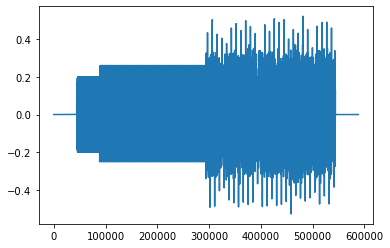

In [700]:
#test, use lower freqs only? N//4 instead of N//2 -1
#symbols = symbols[:N//2-1]
single_frame = known_OFDM_frame(symbols)
ch, inv_ch = define_chirp()
    
#tx_signal, repeats = tx_waveform(single_frame, ch, 100, True, pilot_frame)    
tx_signal, repeats, data_len = tx_waveform_data(single_frame, ch, 100, 'texttst.txt')
plt.plot(tx_signal)

# file naming convention?
filename = 'sound_files/transmit.wav'
sf.write(filename, tx_signal, fs)

In [683]:
#rx_signal = ideal_channel_response(tx_signal)    
rx_signal = real_channel_response(tx_signal) 

conv, peak = matched_filter(rx_signal, inv_ch)

Recording
Finished


In [684]:
diff = -40 # variable
print(len(rx_signal))
smoothed_frame = process_transmission(rx_signal, peak, repeats, diff)

freq_response, imp_response = estimate_channel_response(smoothed_frame, single_frame)

661500


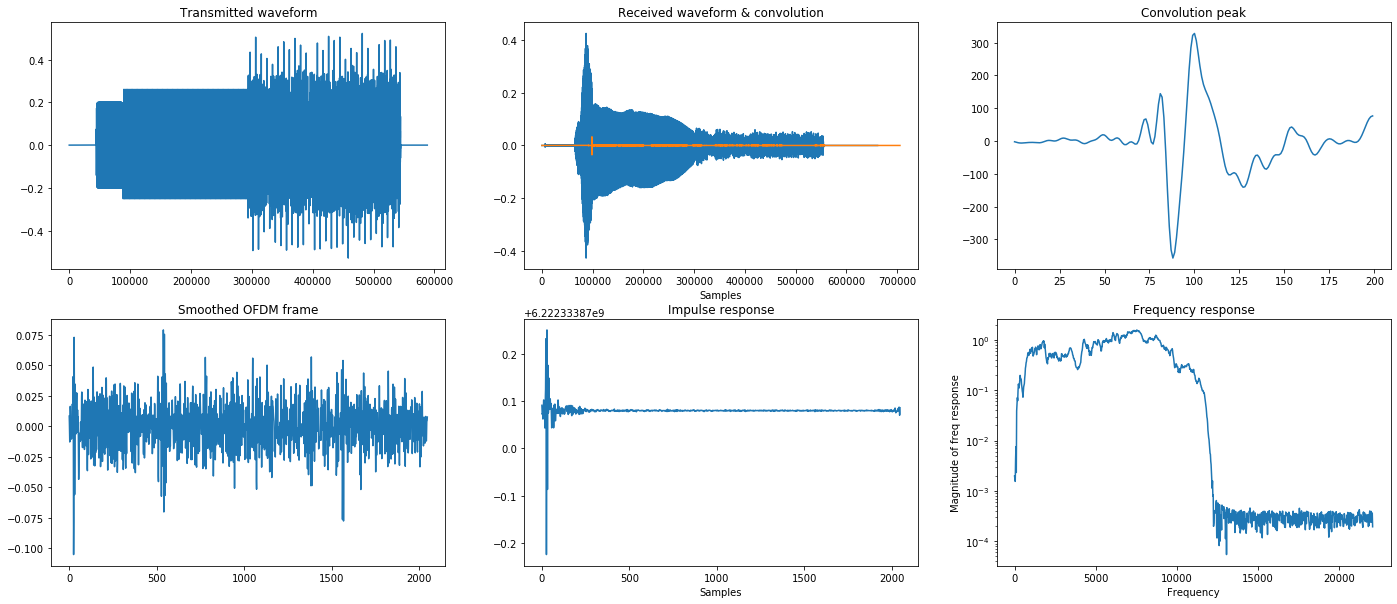

In [729]:
figs, axs = plt.subplots(2, 3, figsize=(24,10))
axs[0][0].plot(tx_signal)
axs[0][0].set_title('Transmitted waveform')
axs[0][1].plot(rx_signal)
axs[0][1].set_title('Received waveform & convolution')
axs[0][1].plot(conv/10000)
axs[0][1].set_xlabel('Samples')
axs[0][2].set_title('Convolution peak')
axs[0][2].plot(conv[peak-100:peak+100])

axs[1][0].set_title('Smoothed OFDM frame')
axs[1][0].plot(smoothed_frame)
axs[1][1].set_title('Impulse response')
axs[1][1].set_xlabel('Samples')
axs[1][1].plot(imp_response[:])
axs[1][2].set_title('Frequency response')
axs[1][2].set_ylabel('Magnitude of freq response')
axs[1][2].set_xlabel('Frequency')
axs[1][2].semilogy(np.linspace(1, fs//2, N//2-1), np.abs(freq_response[1:N//2]))

204800
98663
303463
251136


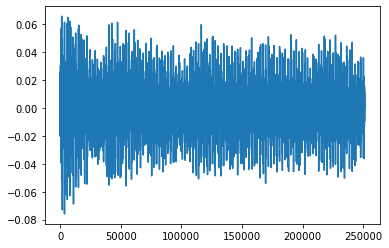

In [722]:
data_begin = peak + repeats*len(single_frame)
print(len(single_frame)*repeats)
print(peak)
print(data_begin)
print(data_len)
plt.plot(rx_signal[data_begin:data_begin+data_len])
data_rx = rx_signal[data_begin:data_begin+data_len]

In [727]:
data_frames = np.split(data_rx, data_len/(N+prefix_no))
frame1 = np.fft.fft(data_frames[0][prefix_no:])
print(frame1)

data = ''
for i in range(len(frame1)):
    element=frame1[i]/ freq_response[i]
    if np.real(element) >= 0:
        if np.imag(element) >= 0:
            data += '00'
        else:
            data += '10'
    else:
        if np.imag(element) >= 0:
            data += '01'
        else:
            data += '11'

bin_strings = data
data_bytes = bitarray(bin_strings)

with open('decode_test.txt', 'wb') as f:
    f.write(data_bytes.tobytes()[:])
print("bitstr written to ",filename)

[-0.00921631+0.j         -0.00958849-0.00465884j -0.0112326 -0.00836167j
 ... -0.00208849+0.01849053j -0.0112326 +0.00836167j
 -0.00958849+0.00465884j]
bitstr written to  sound_files/transmit.wav


C:\Users\11kir\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in cdouble_scalars
  import sys
C:\Users\11kir\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in cdouble_scalars
  import sys


In [ ]:
bits = ""
for i in range(len(data_frames)):
    frame_prefix = data_frames[i][prefix_no:] # remove cp
    frame_dft = np.fft.fft(frame_prefix, n=N)
    bits+=decode_symbols_2_bitstring(frame_dft[1:int(N/2)],freq_response[1:int(N/2)])

#bits_rec=OFDMframes_to_bitstring(data_frames, N, prefix_no, freq_response)
#bitstr_to_file(bits_rec,'decode.txt')

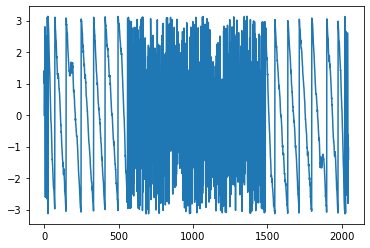

In [443]:
plt.plot(np.angle(freq_response)[:])

381200


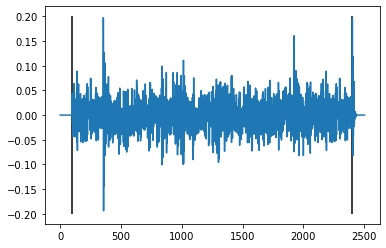

In [556]:
conv2 = np.argmax(conv[peak+1000:]) + peak +1000
print(conv2)
conv2 += fs
plt.plot(rx_signal[conv2-100:conv2+len(pilot_frame)+100])
plt.vlines((100, len(pilot_frame)+100), 0.2, -0.2)

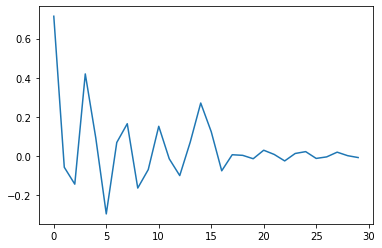

In [582]:

p_block = rx_signal[conv2:conv2+len(pilot_frame)]
freq, imp = estimate_channel_response(p_block[prefix_no:], pilot_frame[prefix_no:]) # take cyclic prefixes off both
plt.plot(imp[:30])
#plt.plot(np.angle(freq))

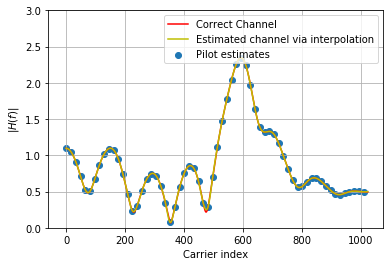

In [624]:
def channelEstimate(OFDM_demod):
    
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue * 2048 # divide by the transmitted pilot values
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase 
    # separately
    
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='cubic', fill_value='extrapolate')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='cubic', fill_value='extrapolate')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    H_exact = np.fft.fft(np.genfromtxt('channel.csv',delimiter=','), N)[:N//2]
    
    plt.plot(allCarriers, abs(H_exact), 'r', label='Correct Channel')
    plt.scatter(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), 'y', label='Estimated channel via interpolation')
    plt.grid(True); plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
    plt.ylim(0,3)
    
    return Hest

OFDM_demod = np.fft.ifft(p_block[prefix_no:])
Hest = channelEstimate(OFDM_demod)

[ 0.00032974-1.09611042j  0.01334321-1.09608004j  0.02641053-1.09550269j
 ...  0.00036786-0.49854549j -0.00125823-0.49916275j
 -0.00292375-0.49985453j]


C:\Users\11kir\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


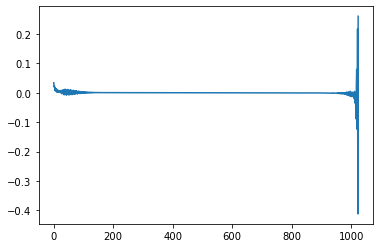

In [628]:
print(Hest)
plt.plot(np.fft.ifft(Hest))

In [223]:
N = 1024 # DFT size
K = 512 # number of OFDM subcarriers with information
CP = K//4  # length of the cyclic prefix
P = K//16# number of pilot carriers per OFDM block
pilotValue = 1+1j # The known value each pilot transmits
 
#Define the payload and pilot carriers
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])
 
pilotCarriers = allCarriers[1::K//P] # Pilots are every (K//P)th carrier.
 
dataCarriers = np.delete(allCarriers, pilotCarriers)
dataCarriers = np.delete(dataCarriers, 0)

Assign relevant values to OFDM symbol:
def OFDM_symbol(QPSK_payload):
    """Assigns pilot values and payload values to OFDM symbol, take reverse complex conjugate and append to end to make signal passband"""
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers
    symbol[dataCarriers] = QPSK_payload  # allocate the data subcarriers
    symbol = np.append(symbol, np.append(0,np.conj(symbol)[:0:-1]))
    return symbol

Main channel estimation function, interpolation done using cubic curves:
def channelEstimate(OFDM_demod, pilotValue):
    """Performs channel estimation using pilot values"""
    # extract the pilot values from the RX signal
    pilots_pos = OFDM_demod[pilotCarriers]     
    pilots_neg = OFDM_demod[-pilotCarriers]

    # divide by the transmitted pilot values
    Hest_at_pilots1 = pilots_pos / pilotValue    
    Hest_at_pilots2 = pilots_neg / np.conj(pilotValue)

    Hest_at_pilots = np.append(Hest_at_pilots1, Hest_at_pilots2).ravel()
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase
    # separately
    Hest_abs = scipy.interpolate.interp1d(np.append(pilotCarriers, N-pilotCarriers).ravel(), abs(Hest_at_pilots), kind='cubic', fill_value="extrapolate")(np.arange(N))
    Hest_phase = scipy.interpolate.interp1d(np.append(pilotCarriers, N-pilotCarriers).ravel(), np.angle(Hest_at_pilots), kind='cubic', fill_value="extrapolate")(np.arange(N))
    Hest = Hest_abs * np.exp(1j*Hest_phase)

    #plt.plot(np.arange(N), abs(Hest), label='Estimated H via cubic interpolation')
    #plt.grid(True); plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
    #plt.show()
    return Hest

SyntaxError: invalid syntax (<ipython-input-223-700b3b2f14c4>, line 15)